<a href="https://colab.research.google.com/github/RVT123123/Model-Prunning/blob/main/Model_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras

In [43]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)


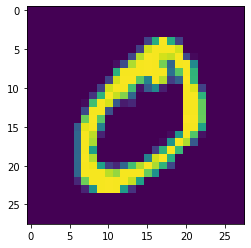

In [4]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[1])

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [7]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [8]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [30]:
from keras.layers import Activation
model = Sequential()
model.add(Convolution2D(128, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPooling2D(2, 2))
#model.add(Dropout(0.5)))
model.add(MaxPooling2D(2, 2))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [31]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                294976    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 296,906
Trainable params: 296,906
Non-trainable params: 0
________________________________________________

In [32]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [33]:
model.fit(X_train, Y_train,batch_size=120, epochs=20, verbose=2)

Epoch 1/20
500/500 - 49s - loss: 0.2663 - accuracy: 0.9236
Epoch 2/20
500/500 - 49s - loss: 0.0842 - accuracy: 0.9744
Epoch 3/20
500/500 - 48s - loss: 0.0654 - accuracy: 0.9800
Epoch 4/20
500/500 - 48s - loss: 0.0519 - accuracy: 0.9837
Epoch 5/20
500/500 - 48s - loss: 0.0448 - accuracy: 0.9863
Epoch 6/20
500/500 - 48s - loss: 0.0383 - accuracy: 0.9883
Epoch 7/20
500/500 - 48s - loss: 0.0342 - accuracy: 0.9894
Epoch 8/20
500/500 - 48s - loss: 0.0289 - accuracy: 0.9914
Epoch 9/20
500/500 - 48s - loss: 0.0265 - accuracy: 0.9916
Epoch 10/20
500/500 - 47s - loss: 0.0232 - accuracy: 0.9927
Epoch 11/20
500/500 - 48s - loss: 0.0201 - accuracy: 0.9936
Epoch 12/20
500/500 - 47s - loss: 0.0167 - accuracy: 0.9952
Epoch 13/20
500/500 - 47s - loss: 0.0149 - accuracy: 0.9955
Epoch 14/20
500/500 - 48s - loss: 0.0136 - accuracy: 0.9959
Epoch 15/20
500/500 - 48s - loss: 0.0113 - accuracy: 0.9964
Epoch 16/20
500/500 - 48s - loss: 0.0104 - accuracy: 0.9971
Epoch 17/20
500/500 - 47s - loss: 0.0077 - accura

In [37]:
original_score = model.evaluate(X_test, Y_test, verbose=0)

In [40]:
print(original_score[1])

0.9896000027656555


In [44]:
tf.keras.models.save_model(model, 'original_model.h5', include_optimizer=False)

**Performing Model Prunning**

In [61]:
! pip install -q tensorflow-model-optimization

In [62]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 10
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_2 (None, 26, 26, 128)       2434      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 13, 13, 128)       1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 6, 6, 128)         1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 4608)              1         
_________________________________________________________________
prune_low_magnitude_dense_8  (None, 64)                589890    
_________________________________________________________________
prune_low_magnitude_dense_9  (None, 10)                1292      
Total params: 593,619
Trainable params: 296,906
Non-trainable params: 296,713
__________________________________________

In [63]:
import tempfile
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(X_train, Y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/10
422/422 [==============================] - 51s 120ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0234 - val_accuracy: 0.9930
Epoch 2/10
422/422 [==============================] - 47s 111ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0214 - val_accuracy: 0.9940
Epoch 3/10
422/422 [==============================] - 47s 111ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0230 - val_accuracy: 0.9940
Epoch 4/10
422/422 [==============================] - 47s 111ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.0223 - val_accuracy: 0.9938
Epoch 5/10
422/422 [==============================] - 47s 111ms/step - loss: 9.9138e-04 - accuracy: 1.0000 - val_loss: 0.0219 - val_accuracy: 0.9942
Epoch 6/10
422/422 [==============================] - 47s 112ms/step - loss: 8.8048e-04 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9938
Epoch 7/10
422/422 [==============================] - 47s 111ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0218 

Comparison of Accuracies

In [64]:
model_for_pruning_score = model_for_pruning.evaluate(
   X_test, Y_test, verbose=0)

print('Baseline test accuracy:', original_score[1]) 
print('Pruned test accuracy:', model_for_pruning_score[1])

Baseline test accuracy: 0.9896000027656555
Pruned test accuracy: 0.9869999885559082


Create 3x smaller models from pruning

In [66]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'pruned_model.h5', include_optimizer=False)

using TFLite for model compression

In [67]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpfu2vn1jr/assets
Saved pruned TFLite model to: /tmp/tmppk4qvi5i.tflite


function for calculating the gzip size

In [69]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [72]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size('/content/original_model.h5')))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size('/content/pruned_model.h5')))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 1112740.00 bytes
Size of gzipped pruned Keras model: 356274.00 bytes
Size of gzipped pruned TFlite model: 347690.00 bytes
